In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

chanhhieudo_dataset_pbl5_path = kagglehub.dataset_download('chanhhieudo/dataset-pbl5')
chanhhieudo_rubbish_keras_default_1_path = kagglehub.model_download('chanhhieudo/rubbish/Keras/default/1')

print('Data source import complete.')


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ===== CẤU HÌNH =====
IMG_SIZE = (224, 224)
NUM_CLASSES = 4
BATCH_SIZE = 64
EPOCHS = 50  # Tăng lên, dùng EarlyStopping để dừng sớm nếu cần

# ===== HÀM XÂY DỰNG MÔ HÌNH =====
def build_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Huấn luyện toàn bộ model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),  # Tăng dropout để chống overfitting
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ===== DỮ LIỆU =====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset-pbl5/data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/dataset-pbl5/data/valid',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 13302 images belonging to 4 classes.
Found 1839 images belonging to 4 classes.


In [ ]:

# ===== MODEL =====
model = build_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# ===== CALLBACKS =====
checkpoint = ModelCheckpoint(
    filepath='model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# ===== TRAIN =====
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

# ===== LƯU MÔ HÌNH SAU TRAIN =====
model.save("final_model.keras")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4435 - loss: 1.2618
Epoch 1: val_loss improved from inf to 1.56114, saving model to model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.4440 - loss: 1.2609 - val_accuracy: 0.2235 - val_loss: 1.5611
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.6856 - loss: 0.8107
Epoch 2: val_loss did not improve from 1.56114
208/208 ━━━━━━━━━━━━━━━━━━━━ 209s 970ms/step - accuracy: 0.6857 - loss: 0.8105 - val_accuracy: 0.1865 - val_loss: 2.0586
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.7348 - loss: 0.7105
Epoch 3: val_loss did not improve from 1.56114
208/208 ━━━━━━━━━━━━━━━━━━━━ 208s 969ms/step - accuracy: 0.7348 - loss: 0.7105 - val_accuracy: 0.2806 - val_loss: 1.6038
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.7647 - loss: 0.6334
Epoch 4: val_loss improved from 1.56114 to 0.84279, saving model to model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy

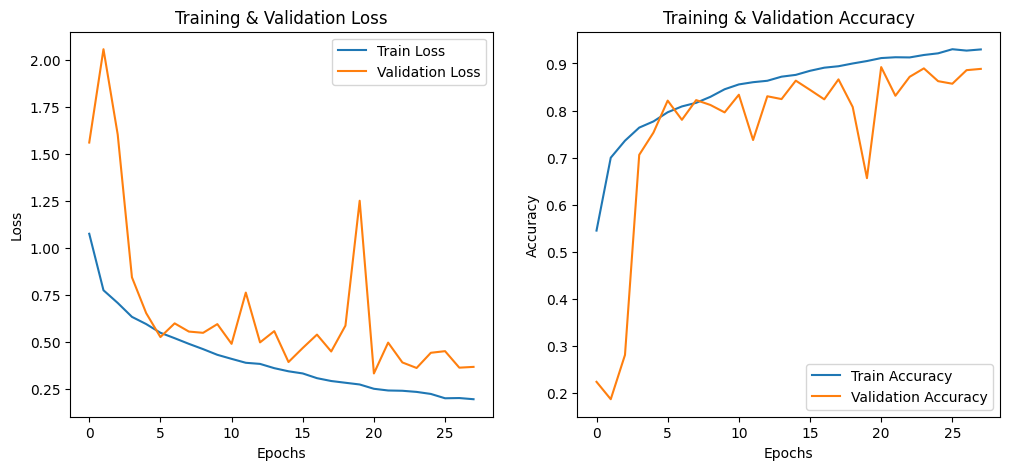

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs_range = range(len(train_loss))

# Vẽ đồ thị
plt.figure(figsize=(12, 5))

# Vẽ loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Vẽ accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
from tensorflow import keras

model = keras.models.load_model("model.keras")

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,558,121 (47.91 MB)

 Trainable params: 4,172,032 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,344,066 (31.83 MB)

In [ ]:
# Bỏ đóng băng base_model nếu bạn muốn fine-tune
model.layers[0].trainable = True

# Compile lại sau khi unfreeze
model.compile(optimizer=Adam(learning_rate=1e-5),  # LR thấp hơn khi fine-tune
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Số epoch tiếp theo
    callbacks=[checkpoint, earlystop],  # Có thể dùng lại callback cũ
    verbose=1
)
model.save("best_model.keras")

Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9234 - loss: 0.2178
Epoch 1: val_loss improved from 0.33020 to 0.26205, saving model to model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9234 - loss: 0.2177 - val_accuracy: 0.9114 - val_loss: 0.2621
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9294 - loss: 0.1957
Epoch 2: val_loss improved from 0.26205 to 0.25844, saving model to model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 188s 877ms/step - accuracy: 0.9294 - loss: 0.1957 - val_accuracy: 0.9152 - val_loss: 0.2584
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9328 - loss: 0.1906
Epoch 3: val_loss did not improve from 0.25844
208/208 ━━━━━━━━━━━━━━━━━━━━ 185s 862ms/step - accuracy: 0.9328 - loss: 0.1906 - val_accuracy: 0.9157 - val_loss: 0.2614
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9362 - loss: 0.1781
Epoch 4: val_loss did not improve from 0.25844
208/208 ━━━━━━━━━━━━━━━━━━━━ 184s 

In [ ]:
from tensorflow import keras

model = keras.models.load_model("model.keras")

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,558,121 (47.91 MB)

 Trainable params: 4,172,032 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,344,066 (31.83 MB)

In [ ]:
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"✅ Validation loss: {val_loss:.4f}")
print(f"✅ Validation accuracy: {val_acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.9186 - loss: 0.2486
✅ Validation loss: 0.2584
✅ Validation accuracy: 0.9152


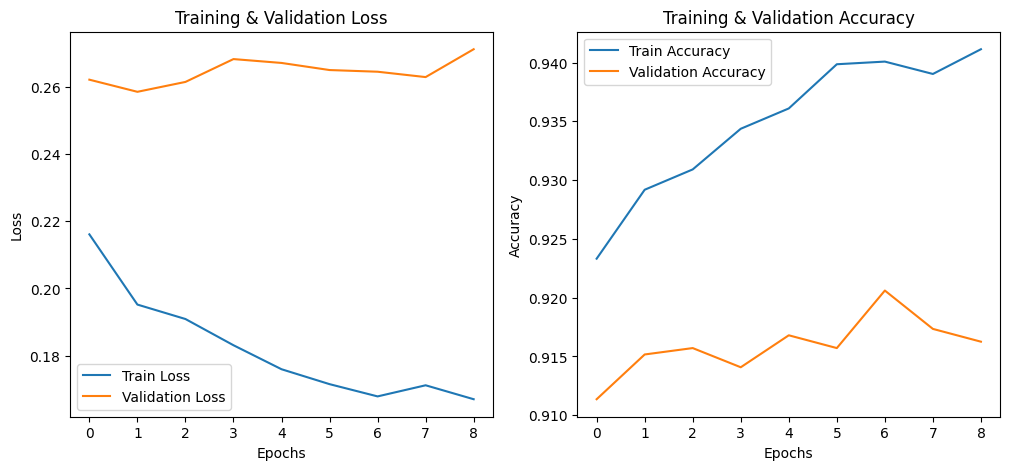

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs_range = range(len(train_loss))

# Vẽ đồ thị
plt.figure(figsize=(12, 5))

# Vẽ loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Vẽ accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:

# Đánh giá model trên tập validation
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.9138 - loss: 0.2711
Validation Loss: 0.2584, Validation Accuracy: 0.9152


Found 977 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


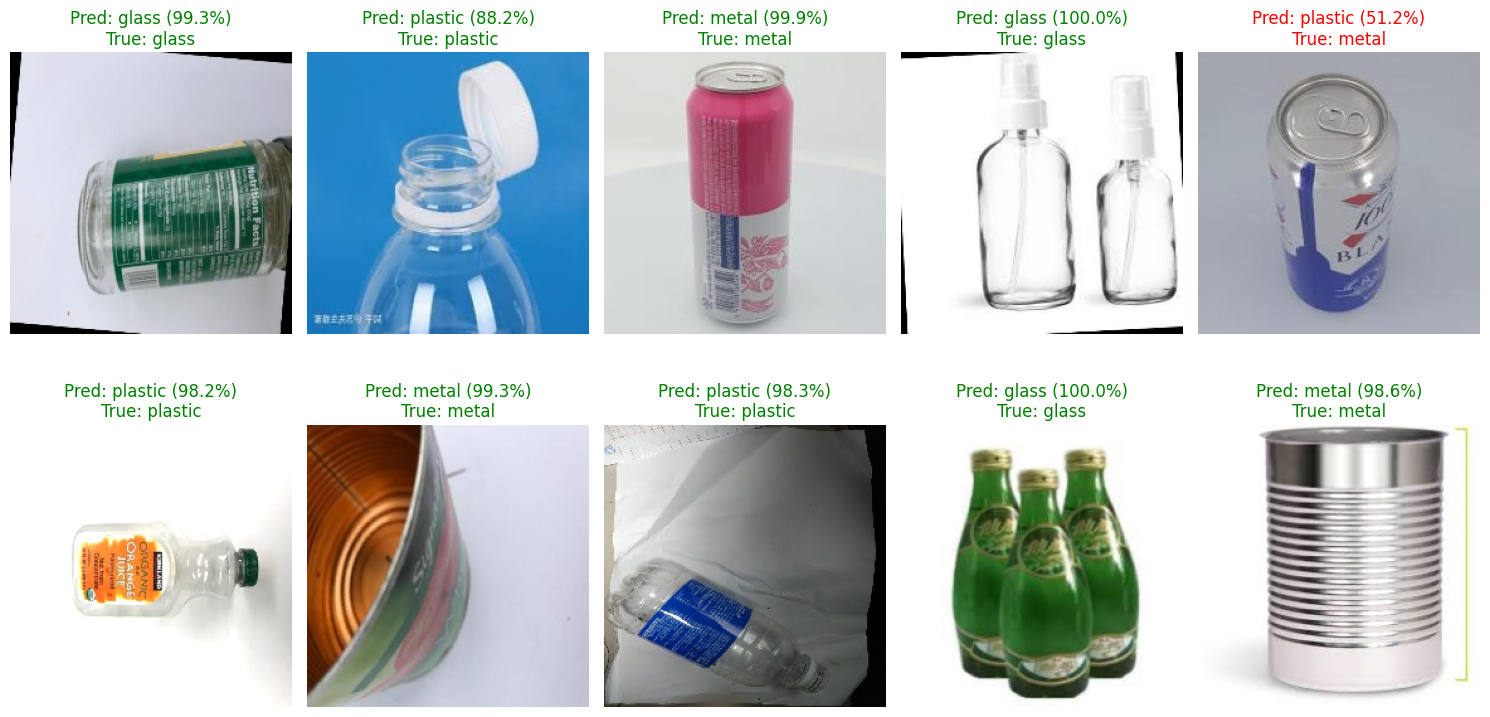

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ===== LOAD MÔ HÌNH TỐT NHẤT =====
model = tf.keras.models.load_model("model.keras")

# ===== TẢI TẬP TEST =====
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset-pbl5/data/test',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

class_labels = list(test_generator.class_indices.keys())

# ===== HIỂN THỊ 10 ẢNH VÀ DỰ ĐOÁN =====
plt.figure(figsize=(15, 8))

for i in range(10):
    img, label = next(test_generator)
  # Lấy 1 ảnh ngẫu nhiên
    pred = model.predict(img)

    true_idx = np.argmax(label)
    pred_idx = np.argmax(pred)
    pred_label = class_labels[pred_idx]
    true_label = class_labels[true_idx]
    confidence = np.max(pred) * 100

    color = 'green' if pred_idx == true_idx else 'red'
    title = f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}"

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 436 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 977 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


977/977 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step


<Figure size 800x600 with 0 Axes>

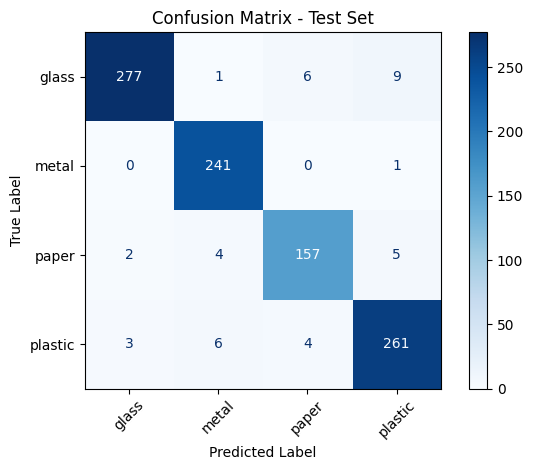

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===== LOAD MÔ HÌNH TỐT NHẤT =====
model = tf.keras.models.load_model("/kaggle/input/rubbish/keras/default/1/model.keras")

# ===== TẢI TẬP TEST =====
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset-pbl5/data/test',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # Không xáo trộn để giữ thứ tự nhãn
)

class_labels = list(test_generator.class_indices.keys())

# ===== DỰ ĐOÁN VÀ TÍNH MA TRẬN NHẦM LANH =====
# Lấy tất cả nhãn thực tế
true_labels = []
for _ in range(int(np.ceil(test_generator.samples / test_generator.batch_size))):
    img, label = next(test_generator)
    true_labels.extend(np.argmax(label, axis=1))

# Đặt lại generator để bắt đầu từ đầu
test_generator.reset()

# Dự đoán trên toàn bộ tập test
predictions = model.predict(test_generator, steps=test_generator.samples)
pred_labels = np.argmax(predictions, axis=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)

# ===== HIỂN THỊ MA TRẬN NHẦM LANH =====
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

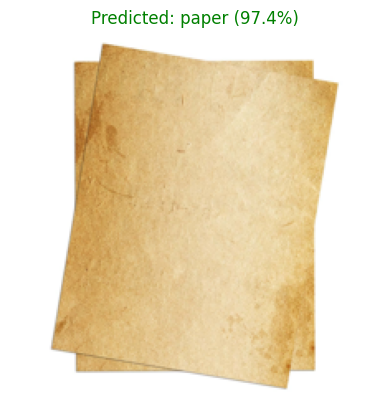

In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from io import BytesIO

# ===== LOAD MODEL =====
model = tf.keras.models.load_model("model.keras")

# ===== CẤU HÌNH =====
IMG_SIZE = (224, 224)
class_labels = ['glass', 'metal', 'paper', 'plastic']  # Thay bằng label thực tế

# ===== 1. TẢI ẢNH TỪ URL =====
image_url = 'https://images-na.ssl-images-amazon.com/images/I/71aJzbOh5iL.jpg'  # Thay bằng ảnh bất kỳ
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img_resized = img.resize(IMG_SIZE)

# ===== 2. TIỀN XỬ LÝ ẢNH =====
img_array = np.array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

# ===== 3. DỰ ĐOÁN =====
pred = model.predict(img_array, verbose=0)
pred_idx = np.argmax(pred)
confidence = np.max(pred) * 100
pred_label = class_labels[pred_idx]

# ===== 4. HIỂN THỊ =====
plt.imshow(img_resized)
plt.title(f"Predicted: {pred_label} ({confidence:.1f}%)", color='green')
plt.axis('off')
plt.show()


In [ ]:
import zipfile

# Nén file lại
with zipfile.ZipFile("/kaggle/working/model.zip", "w") as zipf:
    zipf.write("/kaggle/working/model.keras", arcname="model.keras")
